<a href="https://colab.research.google.com/github/khagerthey/GIS/blob/main/PS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#My Plan
I plan on focusing my research around entrepreneurship. I feel with the useful tool of social media there has been an increase in small businesses. I’m interested in seeing how location within the United States has an effect on the type of businesses, location of buyer vs seller, and correlation between business and local cost of living.

#Resources
https://www.statista.com/statistics/1306812/number-us-etsy-sellers-state/
Here is usable data of the number of sellers in each state! (2021)

https://www.marketplacepulse.com/top-etsy-sellers
Here is usable data of top Etsy sellers! (countries)

US States shapefile link: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

2023 State population table link:
https://worldpopulationreview.com/states

In [1]:
import os, zipfile
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from google.colab import data_table
data_table.enable_dataframe_formatter()

import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline
!pip install mapclassify
import mapclassify
import numpy as np

import matplotlib.patches as mpatches
from pandas.core.interchange.dataframe_protocol import Column

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.3 MB/s eta 0:00:00


#Working with Data

##Merge

I am using the 2022 state's population to compare to the 2021 Etsy Seller US population. My hypothesis is that there is a direct correlation between populations. This is a good place to start to try and determine what drives small business success. I'm thinking more people in one location means more potential buyers.

In [15]:
state_population_raw=pd.read_csv('https://raw.githubusercontent.com/khagerthey/GIS/main/state-population-table.csv')
state_population_columns = state_population_raw[['state', 'pop2022']]
state_population = state_population_columns.rename(columns={'pop2022': 'Total Population in Millions 2022', 'state': 'US State'})
district_of_columbia = pd.DataFrame({'US State': ['District of Columbia'], 'Total Population in Millions 2022': [671803.0]})
puerto_rico = pd.DataFrame({'US State': ['Puerto Rico'], 'Total Population in Millions 2022': [3221789.0]})
combined_states = pd.concat([state_population, district_of_columbia, puerto_rico], ignore_index=True)

combined_states['Total Population in Millions 2022'] = combined_states['Total Population in Millions 2022']/ 100000
combined_states['Total Population in Millions 2022'] = combined_states['Total Population in Millions 2022'].round(1)

combined_states

,US State,Total Population in Millions 2022
0,California,390.3
1,Texas,300.3
2,Florida,222.4
3,New York,196.8
4,Pennsylvania,129.7
5,Illinois,125.8
6,Ohio,117.6
7,Georgia,109.1
8,North Carolina,107.0
9,Michigan,100.3


In [3]:
etsy_us_sellers=pd.read_csv('https://raw.githubusercontent.com/khagerthey/GIS/main/etsy_statessellerstats.csv', header=None)
etsy_us_sellers.columns=["US State", "Etsy Sellers in Thousands 2021"]
etsy_sellers = etsy_us_sellers.replace('Washington, D.C.', 'District of Columbia')
etsy_sellers

,US State,Etsy Sellers in Thousands 2021
0,California,465.6
1,Texas,337.3
2,Florida,302.4
3,New York,251.5
4,Pennsylvania,143.3
5,Illinois,133.9
6,Michigan,130.2
7,Ohio,130.1
8,Georgia,128.5
9,North Carolina,123.3


In [16]:
state_seller_compare = pd.merge(combined_states, etsy_sellers, how='outer', on=['US State'], indicator='true')
state_seller_compare
#everything merged correctly

,US State,Total Population in Millions 2022,Etsy Sellers in Thousands 2021,true
0,California,390.3,465.6,both
1,Texas,300.3,337.3,both
2,Florida,222.4,302.4,both
3,New York,196.8,251.5,both
4,Pennsylvania,129.7,143.3,both
5,Illinois,125.8,133.9,both
6,Ohio,117.6,130.1,both
7,Georgia,109.1,128.5,both
8,North Carolina,107.0,123.3,both
9,Michigan,100.3,130.2,both


We can see from the table that population aligns with sellers.

In [17]:
state_seller_compare['percent'] = (state_seller_compare['Total Population in Millions 2022'] / state_seller_compare['Etsy Sellers in Thousands 2021'].sum()) *100
state_seller_compare.round(1)

,US State,Total Population in Millions 2022,Etsy Sellers in Thousands 2021,true,percent
0,California,390.3,465.6,both,10.2
1,Texas,300.3,337.3,both,7.9
2,Florida,222.4,302.4,both,5.8
3,New York,196.8,251.5,both,5.2
4,Pennsylvania,129.7,143.3,both,3.4
5,Illinois,125.8,133.9,both,3.3
6,Ohio,117.6,130.1,both,3.1
7,Georgia,109.1,128.5,both,2.9
8,North Carolina,107.0,123.3,both,2.8
9,Michigan,100.3,130.2,both,2.6


Added percentage column so that we can see the actual percent of Etsy sellers. This gives a better evaluation.

##Map data

In [9]:
#shapefile of US map states
! wget -q -O cb_2018_us_state_5m.zip https://github.com/khagerthey/GIS/raw/main/cb_2018_us_state_5m.zip


(-127.0, -66.0)

(25.0, 50.0)

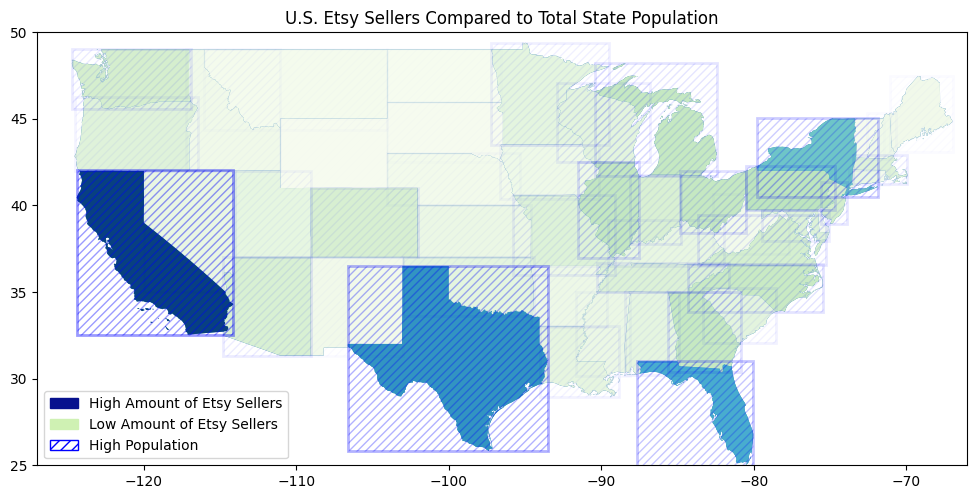

In [18]:
zip_ref = zipfile.ZipFile('cb_2018_us_state_5m.zip', 'r'); zip_ref.extractall(); zip_ref.close() #unzipping
states_map = gpd.read_file('cb_2018_us_state_5m.shp')

ax = states_map.plot(figsize = (12,12))
ax.set_xlim(-127, -66)
ax.set_ylim(25, 50)
ax.title.set_text("U.S. Etsy Sellers Compared to Total State Population")


continental_map_data = states_map.join(state_seller_compare.set_index("US State"),
                                       on="NAME")


new_map_etsy = continental_map_data.plot(column="Etsy Sellers in Thousands 2021",
                                         cmap="GnBu", ax=ax, legend_kwds=
                                          {"fmt": "{:,.Of}", 'loc':'lower right',
                                           'markerscale':1.4})

etsy_legend_high = mpatches.Patch(color='#07118E', label='High Amount of Etsy Sellers')
etsy_legend_low = mpatches.Patch(color='#CFF1B3', label='Low Amount of Etsy Sellers')


continental_map_data['hatch_density'] = continental_map_data['Total Population in Millions 2022'] * 0.001


for idx, row in continental_map_data.iterrows():
  if not np.isnan(row['hatch_density']):
    ax.add_patch(plt.Rectangle((row.geometry.bounds[0], row.geometry.bounds[1]),
                               row.geometry.bounds[2] - row.geometry.bounds[0],
                               row.geometry.bounds[3] - row.geometry.bounds[1],
                               hatch='////', fill=False, edgecolor='blue', linewidth=2, alpha=row['hatch_density']))

blue_legend = mpatches.Patch(edgecolor='blue', facecolor='none', hatch='///', label='High Population')
legend_elements = [etsy_legend_high, etsy_legend_low, blue_legend]
ax.legend(handles=legend_elements, loc='lower left')


plt.show()


#plan to focus on only continental US for right now

The map above displays the amount of Etsy Sellers within the U.S. as of 2021 and the state's population as of 2022. As we can see, states such as California, Texas, and Florida were both high in population and sellers. This is expected, assuming more people in an area leads to more sellers. It's better to compare percentage of total.

<Axes: >

(-127.0, -66.0)

(25.0, 50.0)

[]

[]

Text(0.5, 485.96619430388847, '')

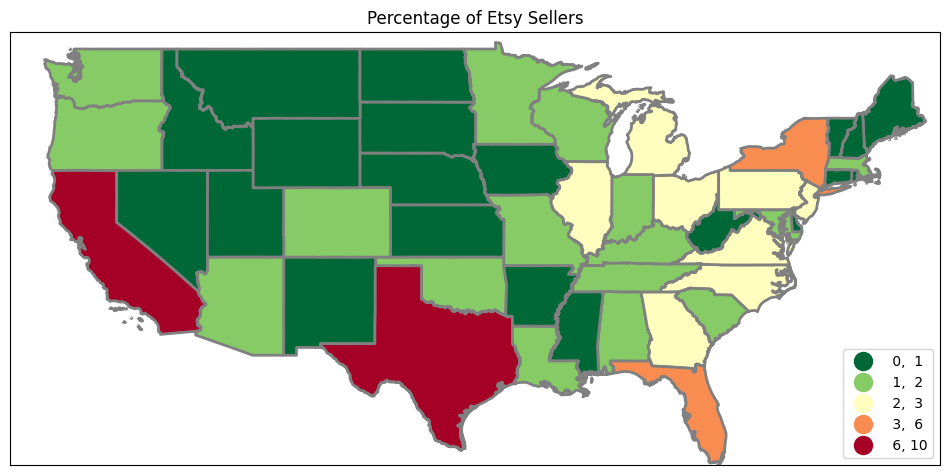

In [14]:
fig, ax = plt.subplots(1, figsize=(12,12))
continental_map_data.plot(ax=ax,column='percent',legend=True,cmap='RdYlGn_r',
          scheme='natural_breaks',k=5, edgecolor='grey',linewidth=2,
          legend_kwds= {"fmt": "{:,.0f}",'loc':'lower right','markerscale':1.4})

ax.set_xlim(-127, -66)
ax.set_ylim(25, 50)
ax.title.set_text("Percentage of Etsy Sellers")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('''''')

 Here we see the percentage of Etsy sellers in each state. The results appear to be the same. I am curious to see how the cost of living compares to the states listed as it may give a motivation for sellers. Next will be to look at the most successful sellers and factors contributing to that.